# **Imports and setup**

The notebook can be run in Google Colab, because the local machine had no GPU. Requirements can be found in requirements.txt

In [ ]:
# !pip install yfinance  # ==0.1.63

In [ ]:
import pandas as pd
import numpy as np

from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, norm

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf
import random

%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device used", device)
random.seed(42)
torch.manual_seed(42)

device used cpu


In [ ]:
# Get the data for SP500 from May 2009 till Dec 2018 (as in the original paper)
# sp500 = yf.download('^GSPC','2009-05-01','2018-12-31')
# import requests
# print("Yahoo angry?:")
# requests.get("https://query1.finance.yahoo.com/v8/finance/chart/GSPC").text

import pandas as pd

url = "https://stooq.com/q/d/l/?s=^spx&i=d"
sp500 = pd.read_csv(url)

sp500["Date"] = pd.to_datetime(sp500["Date"])

mask = (sp500["Date"] >= "2009-05-01") & (sp500["Date"] <= "2018-12-31")
sp500 = sp500.loc[mask].reset_index(drop=True)
sp500.head()

,Date,Open,High,Low,Close,Volume
0,2009-05-01,872.74,880.48,866.10,877.52,2.951206e+09
1,2009-05-04,879.21,907.85,879.21,907.24,3.910467e+09
2,2009-05-05,906.10,907.70,897.34,903.80,3.823811e+09
3,2009-05-06,903.95,920.28,903.95,919.53,4.752800e+09
4,2009-05-07,919.58,929.58,901.36,907.39,5.066722e+09


## **Preprocessing**

In [ ]:
sp500log = np.log(sp500['Close'] / sp500['Close'].shift(1))[1:].values

We see thick tails of distribution:

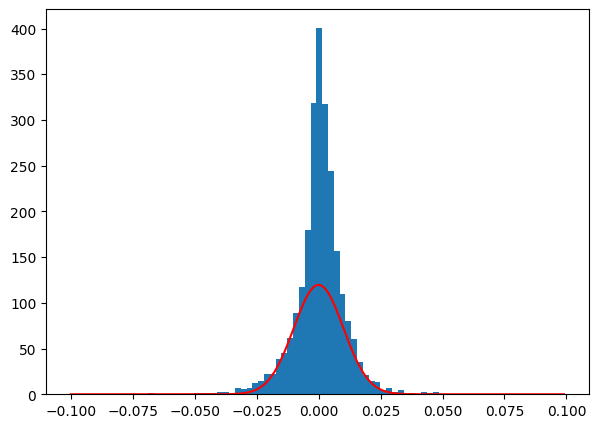

4.074873864760227


In [ ]:
plt.hist(sp500log, bins=50)
x_axis = np.arange(-0.1, 0.1, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.01) * 3, color= 'r')
plt.show()

print(kurtosis(sp500log))

Perform an inverse Lambert transformation and re-normalization using IGMM algorithm.


In [ ]:
def delta_init(z):
    k = kurtosis(z, fisher=False, bias=False)
    if k < 166. / 62.:
        return 0.01
    return np.clip(1. / 66 * (np.sqrt(66 * k - 162.) - 6.), 0.01, 0.48)

def delta_gmm(z):
    delta = delta_init(z)

    def iter(q):
        u = W_delta(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        k = kurtosis(u, fisher=True, bias=False)**2
        if not np.isfinite(k) or k > 1e10:
            return 1e10
        return k

    res = fmin(iter, np.log(delta), disp=0)
    return np.around(np.exp(res[-1]), 6)

def W_delta(z, delta):
    return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)

def W_params(z, params):
    return params[0] + params[1] * W_delta((z - params[0]) / params[1], params[2])

def inverse(z, params):
    return params[0] + params[1] * (z * np.exp(z * z * (params[2] * 0.5)))

def igmm(z, eps=1e-7, max_iter=100):
    delta = delta_init(z)
    params = [np.median(z), np.std(z) * (1. - 2. * delta) ** 0.75, delta]
    for k in range(max_iter):
        params_old = params
        u = (z - params[0]) / params[1]
        params[2] = delta_gmm(u)
        x = W_params(z, params)
        params[0], params[1] = np.mean(x), np.std(x)

        if np.linalg.norm(np.array(params) - np.array(params_old)) < eps:
            print(f"converged at {k}")
            break
        if k == max_iter - 1:
            raise "Solution not found"

    return params

def delta_gmm2(z):
    delta = init_delta_

    def iter(q):
        u = W_delta(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        k = kurtosis(u, fisher=True, bias=False)**2
        if not np.isfinite(k) or k > 1e10:
            return 1e10
        return k

    res = fmin(iter, np.log(delta), disp=0)
    return np.around(np.exp(res[-1]), 6)

def igmm2(z, eps=1e-7, max_iter=100):
    delta = init_delta_
    params = [np.median(z), np.std(z), delta]
    for k in range(max_iter):
        params_old = params.copy()
        u = (z - params[0]) / params[1]
        params[2] = delta_gmm2(u)
        x = W_params(z, params)
        params[0], params[1] = np.mean(x), np.std(x)
        print(params)

        dist = np.linalg.norm(np.array(params) - np.array(params_old))
        if dist < eps:
            print(f"converged after {k+1} iterations")
            break
        if k == max_iter - 1:
            raise "Solution not found"

    return params

init_delta_ = 0.1
sp500log_mean = np.mean(sp500log)
sp500log_norm = sp500log - sp500log_mean
params = igmm2(sp500log_norm)
sp500processed = W_delta((sp500log_norm - params[0]) / params[1], params[2])
sp500max = np.max(np.abs(sp500processed))
sp500processed /= sp500max

[np.float64(0.00014737205063908236), np.float64(0.006748141294654155), np.float64(0.420655)]
[np.float64(0.00014836007411200752), np.float64(0.006748391739619511), np.float64(0.20511)]
[np.float64(0.00014855246356749554), np.float64(0.006748395832733346), np.float64(0.205122)]
[np.float64(0.00014858788054524427), np.float64(0.006748461679809368), np.float64(0.20511)]
[np.float64(0.0001485962044350829), np.float64(0.006748416411830663), np.float64(0.205122)]
[np.float64(0.0001485962024233741), np.float64(0.0067484680641329954), np.float64(0.20511)]
[np.float64(0.00014859776132417304), np.float64(0.006748418466661502), np.float64(0.205122)]
[np.float64(0.000148598596368528), np.float64(0.006748401567120276), np.float64(0.205122)]
converged after 8 iterations


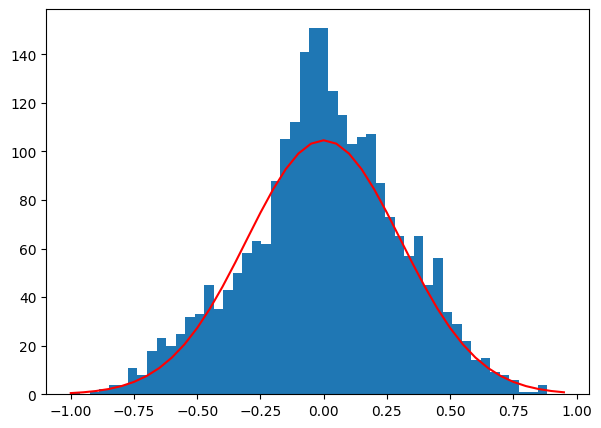

-0.05057320388046849 4.074873864760227


In [ ]:
plt.hist(sp500processed, bins=50)
x_axis = np.arange(-1, 1, 0.05)
std = np.std(sp500processed)
plt.plot(x_axis, norm.pdf(x_axis, 0, std) * 80, color= 'r')
plt.show()
print(f"{kurtosis(sp500processed)} {kurtosis(sp500log)}")

In [ ]:
# Dataset

class SP500Dataset(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = np.expand_dims(self.data[index:index+self.window], -1)
        return torch.from_numpy(x).float()

    def __len__(self):
        return len(self.data) - self.window

# **Models for GAN**

In [ ]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs, kernel_size, dilation):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_hidden, kernel_size, stride=1, dilation=dilation, padding='same')

        self.relu1 = nn.PReLU()
        self.conv2 = nn.Conv1d(n_hidden, n_outputs, kernel_size, stride=1, dilation=dilation, padding='same')
        self.relu2 = nn.PReLU()

        self.net = nn.Sequential(self.conv1, self.relu1, self.conv2, self.relu2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None

        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=80):
        super(TCN, self).__init__()
        layers = []
        for i in range(7):
            num_inputs = input_size if i == 0 else n_hidden
            kernel_size = 2 if i > 0 else 1
            dilation = 2 * dilation if i > 1 else 1
            layers += [TemporalBlock(num_inputs, n_hidden, n_hidden, kernel_size, dilation)]
        self.conv = nn.Conv1d(n_hidden, output_size, 1)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        self.conv.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.net(x.transpose(1, 2))
        return self.conv(y1).transpose(1, 2)

class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
        return torch.tanh(self.net(x))

class Discriminator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
      return self.net(x)

# **Prepare and train GAN**

In [ ]:
clip_value = 0.01  # 0.01 original
lr = 0.0002  # 0.0002 original 0.001 worked well with sigmoid activation
num_epochs = 100  # 50, 100 worked better
nz = 3
batch_size = 30  # 30
seq_len = 127
gen_train_frequency = 3  # 5

netG = Generator(nz, 1).to(device)
netD = Discriminator(1, 1).to(device)
optD = optim.Adam(netD.parameters(), lr=lr)  # RMSprop original
optG = optim.Adam(netG.parameters(), lr=lr)

dataset = SP500Dataset(sp500processed, 127)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
t = tqdm(range(num_epochs))
for epoch in t:
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()
        real = data.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        noise = torch.randn(batch_size, seq_len, nz, device=device)
        fake = netG(noise).detach()

        lossD = -torch.mean(netD(real)) + torch.mean(netD(fake))
        lossD.backward()
        optD.step()

        for p in netD.parameters():
            p.data.clamp_(-clip_value, clip_value)

        if i % gen_train_frequency == 0:
            netG.zero_grad()
            lossG = -torch.mean(netD(netG(noise)))
            lossG.backward()
            optG.step()
    #Report metrics
    t.set_description('Loss_D: %.8f Loss_G: %.8f' % (lossD.item(), lossG.item()))

    # Checkpoint
    torch.save(netG, 'sp500_netG_epoch_%d.pth' % epoch)
    torch.save(netD, 'sp500_netD_epoch_%d.pth' % epoch)


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(
Loss_D: -1.56517482 Loss_G: 1.86763585: 100%|██████████| 100/100 [1:05:58<00:00, 39.58s/it]


#**Probe generation**

In [ ]:
# noise = torch.randn(1, 2432, 3, device=device)
# fake = netG(noise).detach().cpu().reshape(2432).numpy()
# plt.hist(fake, bins=50)
# plt.show()

Now we revert preprocessing steps to get a simulated trajectory.

In [ ]:
# sp500fake = inverse(fake * sp500max, params)

In [ ]:
# plt.hist(sp500fake, bins=50)
# plt.show()

## Visualize results

In [ ]:
def generate_fakes(n=1, cumsum=True, length=2432):
  fakes = []
  for i in range(n):
    noise = torch.randn(1, length, 3, device=device)
    fake = netG(noise).detach().cpu().reshape(length).numpy()
    sp500fake = inverse(fake * sp500max, params) + sp500log_mean
    fakes.append(sp500fake)
  if n > 1:
    if not cumsum:
      return pd.DataFrame(fakes).T
    fakes_df = pd.DataFrame(fakes).T.cumsum()
    return fakes_df
  elif not cumsum:
    return sp500fake
  return sp500fake.cumsum()

In [ ]:
d = generate_fakes(n=100, cumsum=False)
np.save("gan_data.npy", d)
d.shape

(2432, 100)

In [ ]:
# plt.figure(figsize=(10,6))
# plt.plot(generate_fakes(5), linewidth=1, alpha=0.7)
# plt.legend('')
# plt.grid(True)
# plt.xlabel('T (number of days')
# plt.ylabel('Log path')
# plt.title('5 generated log paths');

In [ ]:
# plt.figure(figsize=(10,6))
# plt.plot(generate_fakes(50), linewidth=1, alpha=0.7)
# plt.legend('')
# plt.grid(True)
# plt.xlabel('T (number of days')
# plt.ylabel('Log path')
# plt.title('50 generated log paths');

In [ ]:
# comp_df = pd.DataFrame({'fake': generate_fakes(length=10000), 'real': sp500log.cumsum()[:-1]})  # probably his code didn't include final day's price (?)
# comp_df.plot()

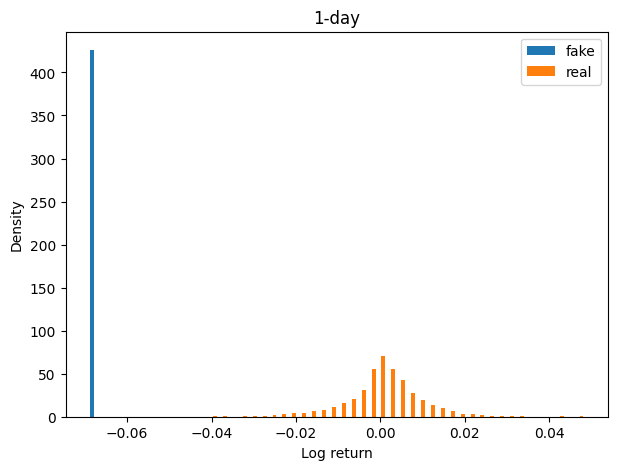

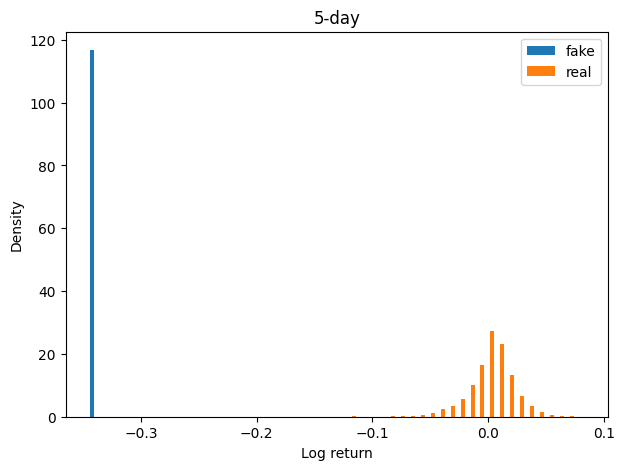

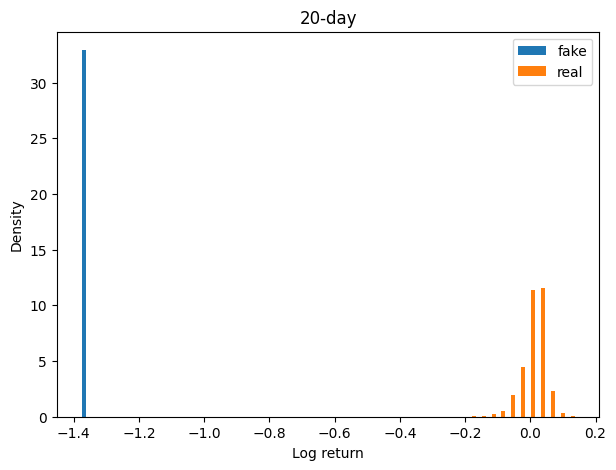

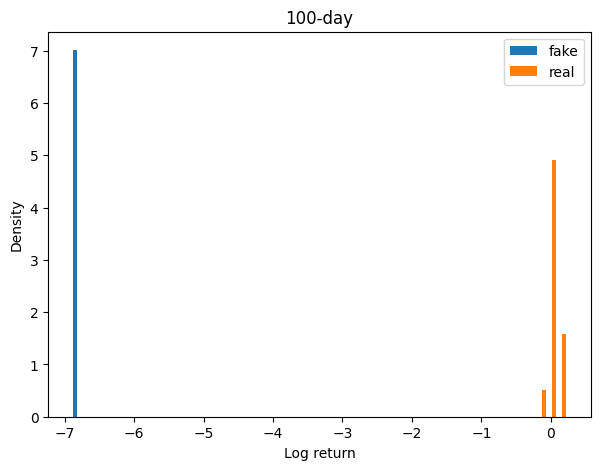

In [ ]:
fake = generate_fakes(length=15000)
real = sp500log.cumsum()
idx = [1, 5, 20, 100]

for step in idx:
  d1 = [fake[i+step]-fake[i] for i in range(len(fake)-step)]
  d2 = [real[i+step]-real[i] for i in range(len(real)-step)]
  plt.hist([d1, d2],
            bins=50, label=['fake', 'real'], density=True)
  plt.legend(loc='upper right')
  plt.xlabel('Log return')
  plt.ylabel('Density')
  plt.title(f'{step}-day')
  plt.show()

In [ ]:
# plt.hist([comp_df['fake'].diff(), comp_df['real'].diff()], bins=50, label=['fake', 'real'])
# plt.legend(loc='upper right')
# plt.xlabel('Log return')
# plt.ylabel('Density')
# plt.title('Daily')
# plt.show()

In [ ]:
# plt.hist([comp_df['fake'].diff(5), comp_df['real'].diff(5)], bins=50, label=['fake', 'real'])
# plt.legend(loc='upper right')
# plt.xlabel('Log return')
# plt.ylabel('Density')
# plt.title('Weekly')
# plt.show()

In [ ]:
# plt.hist([comp_df['fake'].diff(20), comp_df['real'].diff(20)], bins=50, label=['fake', 'real'])
# plt.legend(loc='upper right')
# plt.xlabel('Log return')
# plt.ylabel('Density')
# plt.title('Monthly')
# plt.show()

In [ ]:
# plt.hist([comp_df['fake'].diff(100), comp_df['real'].diff(100)], bins=50, label=['fake', 'real'])
# plt.legend(loc='upper right')
# plt.xlabel('Log return')
# plt.ylabel('Density')
# plt.title('100-day')
# plt.show()

In [ ]:
# def autocorr(x, n=50):
#   if len(x.shape) > 1:
#     x = x.mean(axis=1)
#   result = np.correlate(x, x, mode='full')
#   return pd.DataFrame(result[result.size//2:][:n])

In [ ]:
# fakes = generate_fakes(cumsum=False)
# correlations_normal_real = autocorr(sp500log)
# correlations_normal_fake = autocorr(fakes)

# plt.plot(correlations_normal_real, label='real')
# plt.plot(correlations_normal_fake, label='fake')
# plt.grid(True)
# plt.legend()
# plt.title('Autocorrelation for generated and real data (1 run)')
# plt.xlabel('Lag (number of days)')
# plt.ylabel('Autocorrelation')
# plt.show()

In [ ]:
# fakes = generate_fakes(50, cumsum=False)
# correlations_normal_real = autocorr(sp500log)
# correlations_normal_fake = autocorr(fakes)

# plt.plot(correlations_normal_real, label='real')
# plt.plot(correlations_normal_fake, label='fake')
# plt.grid(True)
# plt.legend()
# plt.title('Autocorrelation for generated and real data (50 runs)')
# plt.xlabel('Lag (number of days)')
# plt.ylabel('Autocorrelation')
# plt.show()

In [ ]:
#!pip freeze > requirements.txt